# PN2V Prediction
Please run the 'Mouse-0-GetData', 'Mouse-1-CreateNoiseModel', and 'Mouse-2-Training' notebooks first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
path="data/Confocal_MICE/raw/"
dataTest=np.load(path+'test_raw.npy').astype(np.float32)
dataTestGT=np.load(path+'../gt/test_gt.npy').astype(np.float32)

### Load the Network and Noise Model

In [3]:
# We are loading the histogram from the 'Mouse-1-CreateNoiseModel' notebook.
histogram=np.load(path+'noiseModel.npy')

# Create a NoiseModel object from the histogram.
noiseModel=histNoiseModel.NoiseModel(histogram, device=device)


In [6]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"last_mouse0.net")

### Evaluation
Note that PSNR values can vary over multiple training runs.

image: 0
PSNR input 29.360938464281006
PSNR prior 37.44986848146139
PSNR mse 38.072413380553066
-----------------------------------
image: 1
PSNR input 29.387083873902426
PSNR prior 37.490756327584386
PSNR mse 38.121826440040756
-----------------------------------
image: 2
PSNR input 29.316595889388118
PSNR prior 37.402405429024896
PSNR mse 38.02062682922071
-----------------------------------
image: 3
PSNR input 29.327664844533793
PSNR prior 37.417756920394496
PSNR mse 38.055872220576404
-----------------------------------
image: 4
PSNR input 29.365894062057343
PSNR prior 37.528418125389564
PSNR mse 38.18013949070111
-----------------------------------
image: 5
PSNR input 29.3544902068618
PSNR prior 37.476565212814364
PSNR mse 38.15854298800363
-----------------------------------
image: 6
PSNR input 29.371914080294992
PSNR prior 37.33773541936506
PSNR mse 37.986972616562184
-----------------------------------
image: 7
PSNR input 29.388815723884054
PSNR prior 37.53231593302096
PSNR mse

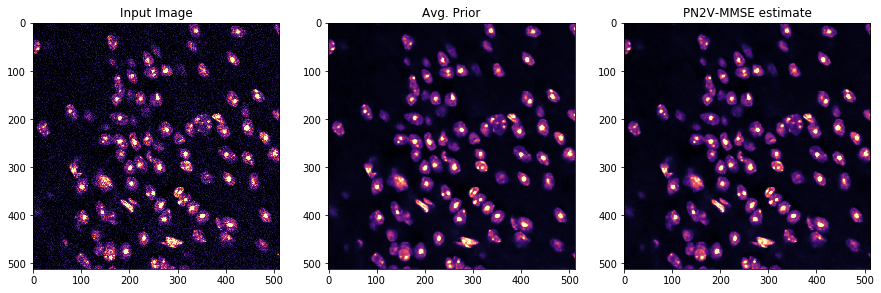

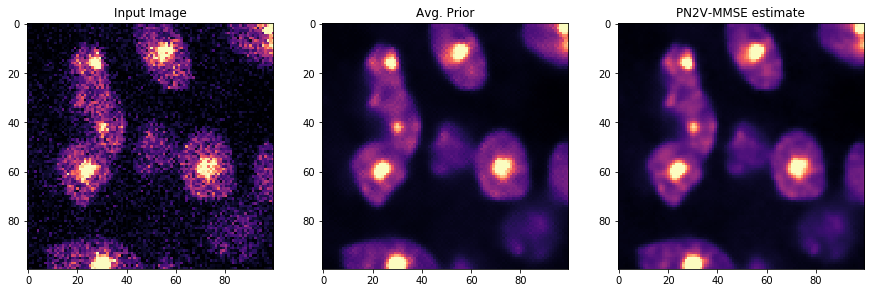

Avg PSNR Prior: 37.52020084511005 +-(2SEM) 0.020501740526811685
Avg PSNR MMSE: 38.1757240923708 +-(2SEM) 0.02373160999308201


In [7]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=noiseModel)
    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=255.0
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )